In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

from category_encoders.one_hot import OneHotEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders import TargetEncoder, WOEEncoder, MEstimateEncoder

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.feature_selection import RFE

from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('new-data.csv', index_col=0)
print('data shape:', data.shape)
data.head()

data shape: (594643, 17)


customer  age gender       merchant             category  amount  \
0  'C1093826151'  '4'    'M'   'M348934600'  'es_transportation'    4.55   
1   'C352968107'  '2'    'M'   'M348934600'  'es_transportation'   39.68   
2  'C2054744914'  '4'    'F'  'M1823072687'  'es_transportation'   26.89   
3  'C1760612790'  '3'    'M'   'M348934600'  'es_transportation'   17.25   
4   'C757503768'  '5'    'M'   'M348934600'  'es_transportation'   35.72   

   fraud  amount_outlier  amount_outlier_2  strange_amount  pda  pdg  \
0      0               0                 0               0    1    0   
1      0               0                 0               0    0    0   
2      0               0                 0               0    1    1   
3      0               0                 0               0    1    0   
4      0               0                 0               0    0    0   

   danger_merch  danger_custm  danger_categ  strange_category  \
0             0             0             0                 0   
1             0             0             0                 0   
2             0             0             0                 0   
3             0             0             0                 0   
4             0             0             0                 0   

   strange_merchant  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [3]:
categorical_features_all = list(data.select_dtypes('object').columns)
print('categorical features (all):', categorical_features_all)
categorical_features = list(data.drop('customer', axis=1).select_dtypes('object').columns)
print('categorical features      :', categorical_features)

categorical features (all): ['customer', 'age', 'gender', 'merchant', 'category']
categorical features      : ['age', 'gender', 'merchant', 'category']


In [21]:
from sklearn.model_selection import train_test_split

X = data.drop('fraud', axis=1)
y = data['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

woe = WOEEncoder(cols=categorical_features_all)
woe.fit(X_train, y_train)
X_train = woe.transform(X_train)
X_test = woe.transform(X_test)

# Кластеризация

In [4]:
from sklearn.cluster import KMeans
from hdbscan import HDBSCAN
from sklearn.decomposition import PCA

In [6]:
# kmeans
kmeans = KMeans(n_clusters=3)
kmeans_result_train = kmeans.fit_predict(X_train)
kmeans_result_test = kmeans.fit_predict(X_test)

In [7]:
kmeans_result_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [8]:
# hdbscan
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

hdbscan = HDBSCAN(min_cluster_size=60, min_samples=10)
hdbscan_result_train = hdbscan.fit_predict(X_train_scaled)
hdbscan_result_test  = hdbscan.fit_predict(X_test_scaled)

In [9]:
hdbscan_result_train

array([974, 972, 766, ..., 848, 672, 325])

In [10]:
# pca
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.fit_transform(X_test)

# Поиск аномалий

In [8]:
from __future__ import division
from __future__ import print_function

import os
import sys
from time import time

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA

from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score

In [12]:
X = data.drop('fraud', axis=1)
y = data['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

ohe = WOEEncoder(cols=categorical_features_all)
ohe.fit(X_train, y_train)

X_train_ohe = ohe.transform(X_train)
X_test_ohe = ohe.transform(X_test)

X_train_norm = standardizer(X_train_ohe)
X_test_norm  = standardizer(X_test_ohe)

In [13]:
# добавляем их в датасет
X_train['kmeans'] = kmeans_result_train
X_test['kmeans'] = kmeans_result_test

X_train['hdbscan'] = hdbscan_result_train
X_test['hdbscan'] = hdbscan_result_test

X_train['pca_x'] = X_train_2d[:, 0]
X_train['pca_y'] = X_train_2d[:, 1]

X_test['pca_x'] = X_test_2d[:, 0]
X_test['pca_y'] = X_test_2d[:, 1]

In [14]:
X_train

customer  age gender       merchant             category  amount  \
168395  'C1825950751'  '4'    'F'  'M1823072687'  'es_transportation'    5.54   
368370   'C759915530'  '2'    'M'  'M1823072687'  'es_transportation'   16.91   
179485  'C1007572087'  '2'    'F'   'M348934600'  'es_transportation'   13.66   
118891  'C1940951230'  '2'    'F'  'M1823072687'  'es_transportation'   41.79   
83228   'C2016997607'  '2'    'M'  'M1823072687'  'es_transportation'   14.72   
...               ...  ...    ...            ...                  ...     ...   
54114   'C1633477199'  '2'    'M'   'M348934600'  'es_transportation'   27.59   
437159  'C1939349733'  '2'    'M'  'M1823072687'  'es_transportation'   13.55   
127674   'C785603838'  '5'    'M'  'M1823072687'  'es_transportation'   22.07   
149824  'C1201696181'  '4'    'F'   'M348934600'  'es_transportation'   24.93   
398588  'C1747513604'  '6'    'M'  'M1823072687'  'es_transportation'    3.12   

        amount_outlier  amount_outlier_2  strange_amount  pda  pdg  \
168395               0                 0               0    1    1   
368370               0                 0               0    0    0   
179485               0                 0               0    0    1   
118891               0                 0               0    0    1   
83228                0                 0               0    0    0   
...                ...               ...             ...  ...  ...   
54114                0                 0               0    0    0   
437159               0                 0               0    0    0   
127674               0                 0               0    0    0   
149824               0                 0               0    1    1   
398588               0                 0               0    0    0   

        danger_merch  danger_custm  danger_categ  strange_category  \
168395             0             0             0                 0   
368370             0             0             0                 0   
179485             0             0             0                 0   
118891             0             0             0                 0   
83228              0             0             0                 0   
...              ...           ...           ...               ...   
54114              0             0             0                 0   
437159             0             0             0                 0   
127674             0             0             0                 0   
149824             0             0             0                 0   
398588             0             0             0                 0   

        strange_merchant  kmeans  hdbscan      pca_x     pca_y  
168395                 0       0      974 -32.448292  1.261973  
368370                 0       0      972 -21.079168  1.399849  
179485                 0       0      766 -24.323691  1.050236  
118891                 0       0      940   3.799019  1.698055  
83228                  0       0      968 -23.268987  1.372874  
...                  ...     ...      ...        ...       ...  
54114                  0       0      872 -10.396877  1.293194  
437159                 0       0     1006 -24.438966  1.361117  
127674                 0       0      848 -15.919543  1.461635  
149824                 0       0      672 -13.055530  1.220790  
398588                 0       0      325 -34.867197  1.200739  

[475714 rows x 20 columns]

In [15]:
outliers_fraction = 0.012256508291017171
outliers_percentage = round(outliers_fraction * 100, ndigits=4)
random_state = 13

classifiers = {
    'CBLOF': CBLOF(
        contamination=outliers_fraction, check_estimator=False,
        random_state=random_state),
    'HBOS': HBOS(
        contamination=outliers_fraction),
    'IF': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'MCD': MCD(
        contamination=outliers_fraction, random_state=random_state)
}

for clf_name, clf in classifiers.items():
    clf.fit(X_train_norm)

    # scores
    train_scores = clf.decision_function(X_train_norm)
    test_scores  = clf.decision_function(X_test_norm)

    X_train[clf_name] = train_scores
    X_test[clf_name]  = test_scores

In [16]:
X_train

customer  age gender       merchant             category  amount  \
168395  'C1825950751'  '4'    'F'  'M1823072687'  'es_transportation'    5.54   
368370   'C759915530'  '2'    'M'  'M1823072687'  'es_transportation'   16.91   
179485  'C1007572087'  '2'    'F'   'M348934600'  'es_transportation'   13.66   
118891  'C1940951230'  '2'    'F'  'M1823072687'  'es_transportation'   41.79   
83228   'C2016997607'  '2'    'M'  'M1823072687'  'es_transportation'   14.72   
...               ...  ...    ...            ...                  ...     ...   
54114   'C1633477199'  '2'    'M'   'M348934600'  'es_transportation'   27.59   
437159  'C1939349733'  '2'    'M'  'M1823072687'  'es_transportation'   13.55   
127674   'C785603838'  '5'    'M'  'M1823072687'  'es_transportation'   22.07   
149824  'C1201696181'  '4'    'F'   'M348934600'  'es_transportation'   24.93   
398588  'C1747513604'  '6'    'M'  'M1823072687'  'es_transportation'    3.12   

        amount_outlier  amount_outlier_2  strange_amount  pda  ...  \
168395               0                 0               0    1  ...   
368370               0                 0               0    0  ...   
179485               0                 0               0    0  ...   
118891               0                 0               0    0  ...   
83228                0                 0               0    0  ...   
...                ...               ...             ...  ...  ...   
54114                0                 0               0    0  ...   
437159               0                 0               0    0  ...   
127674               0                 0               0    0  ...   
149824               0                 0               0    1  ...   
398588               0                 0               0    0  ...   

        strange_category  strange_merchant  kmeans  hdbscan      pca_x  \
168395                 0                 0       0      974 -32.448292   
368370                 0                 0       0      972 -21.079168   
179485                 0                 0       0      766 -24.323691   
118891                 0                 0       0      940   3.799019   
83228                  0                 0       0      968 -23.268987   
...                  ...               ...     ...      ...        ...   
54114                  0                 0       0      872 -10.396877   
437159                 0                 0       0     1006 -24.438966   
127674                 0                 0       0      848 -15.919543   
149824                 0                 0       0      672 -13.055530   
398588                 0                 0       0      325 -34.867197   

           pca_y     CBLOF      HBOS        IF        MCD  
168395  1.261973  0.968791 -5.591645 -0.309967   5.971338  
368370  1.399849  1.230397 -4.913999 -0.325128   3.827154  
179485  1.050236  1.464723 -3.235346 -0.279845  47.208131  
118891  1.698055  0.836461 -5.410100 -0.322465   4.293914  
83228   1.372874  1.226079 -4.913999 -0.324585   3.970185  
...          ...       ...       ...       ...        ...  
54114   1.293194  1.199478 -4.913999 -0.316431   4.560615  
437159  1.361117  1.245077 -4.913999 -0.324636   4.202361  
127674  1.461635  1.623530 -3.444500 -0.305205   6.403964  
149824  1.220790  0.936302 -3.810723 -0.290869  14.947247  
398588  1.200739  2.911664 -1.205649 -0.215260  32.785575  

[475714 rows x 24 columns]

In [17]:
X_train_new = X_train.copy()
X_test_new  = X_test.copy()

# Encoder Selection

In [4]:
from category_encoders.one_hot import OneHotEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders import TargetEncoder, WOEEncoder, MEstimateEncoder

In [23]:
# Подбираем оптимальные кодировки для модели LogisticRegression

encoders_list = [OneHotEncoder, LeaveOneOutEncoder, TargetEncoder, WOEEncoder, MEstimateEncoder]

for encoder in encoders_list:
    pipeline = Pipeline([
        ('categ_enc_', encoder(cols=categorical_features)),
        ('customer_enc_', TargetEncoder(cols=['customer'])),
        ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
        ('scaler_', StandardScaler()),
        ('model_', LogisticRegression())                
    ])

    crossval_results = cross_validate(
        pipeline,
        X_train, 
        y_train, 
        cv=5,
        scoring='average_precision',
        n_jobs=-1,
        return_train_score=True
    )
    print(encoder.__name__, crossval_results['test_score'].mean())

OneHotEncoder 0.9265826624338661
LeaveOneOutEncoder 0.9061101617172624
TargetEncoder 0.9061700773882627
WOEEncoder 0.9074973820360167
MEstimateEncoder 0.9062011277365871


In [21]:
# Подбираем оптимальные кодировки для модели CatBoostClassifier

encoders_list = [OneHotEncoder, LeaveOneOutEncoder, TargetEncoder, WOEEncoder, MEstimateEncoder]

for encoder in encoders_list:
    pipeline = Pipeline([
        ('categ_enc_', encoder(cols=categorical_features)),
        ('customer_enc_', WOEEncoder(cols=['customer'])),
        ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
        ('scaler_', StandardScaler()),
        ('model_', CatBoostClassifier(logging_level='Silent'))                
    ])

    crossval_results = cross_validate(
        pipeline,
        X_train, 
        y_train, 
        cv=5,
        scoring='average_precision',
        n_jobs=-1,
        return_train_score=True
    )
    print(encoder.__name__, crossval_results['test_score'].mean())

OneHotEncoder 0.9076878026509159
LeaveOneOutEncoder 0.8247190396688042
TargetEncoder 0.9074774206404825
WOEEncoder 0.910779827648185
MEstimateEncoder 0.9098859460626667


In [22]:
# Подбираем оптимальные кодировки для модели RandomForestClassifier

encoders_list = [OneHotEncoder, LeaveOneOutEncoder, TargetEncoder, WOEEncoder, MEstimateEncoder]

for encoder in encoders_list:
    pipeline = Pipeline([
        ('categ_enc_', encoder(cols=categorical_features)),
        ('customer_enc_', WOEEncoder(cols=['customer'])),
        ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
        ('scaler_', StandardScaler()),
        ('model_', RandomForestClassifier())                
    ])

    crossval_results = cross_validate(
        pipeline,
        X_train, 
        y_train, 
        cv=5,
        scoring='average_precision',
        n_jobs=-1,
        return_train_score=True
    )
    print(encoder.__name__, crossval_results['test_score'].mean())

OneHotEncoder 0.9164236703135342
LeaveOneOutEncoder 0.8226726010366358
TargetEncoder 0.9119373556749846
WOEEncoder 0.9119159811800708
MEstimateEncoder 0.9122600252255564


In [26]:
print('Done')

Done


In [28]:
# Подбираем оптимальные кодировки для модели LogisticRegression

encoders_list = [OneHotEncoder, LeaveOneOutEncoder, TargetEncoder, WOEEncoder, MEstimateEncoder]

for encoder in encoders_list:
    pipeline = Pipeline([
        ('categ_enc_', encoder(cols=categorical_features)),
        ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
        ('scaler_', StandardScaler()),
        ('model_', LogisticRegression())                
    ])

    crossval_results = cross_validate(
        pipeline,
        X_train.drop('customer', axis=1), 
        y_train, 
        cv=5,
        scoring='average_precision',
        n_jobs=-1,
        return_train_score=True
    )
    print(encoder.__name__, crossval_results['test_score'].mean())

OneHotEncoder 0.9279483392007801
LeaveOneOutEncoder 0.9080071692886001
TargetEncoder 0.9080403156646624
WOEEncoder 0.9090744209542427
MEstimateEncoder 0.9081371168723777


In [29]:
# Подбираем оптимальные кодировки для модели CatBoostClassifier

encoders_list = [OneHotEncoder, LeaveOneOutEncoder, TargetEncoder, WOEEncoder, MEstimateEncoder]

for encoder in encoders_list:
    pipeline = Pipeline([
        ('categ_enc_', encoder(cols=categorical_features)),
        ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
        ('scaler_', StandardScaler()),
        ('model_', CatBoostClassifier(logging_level='Silent'))                
    ])

    crossval_results = cross_validate(
        pipeline,
        X_train.drop('customer', axis=1),
        y_train, 
        cv=5,
        scoring='average_precision',
        n_jobs=-1,
        return_train_score=True
    )
    print(encoder.__name__, crossval_results['test_score'].mean())

OneHotEncoder 0.9295396089585454
LeaveOneOutEncoder 0.8223422201941837
TargetEncoder 0.9289979252385976
WOEEncoder 0.9292176773767629
MEstimateEncoder 0.9295644578676605


In [30]:
# Подбираем оптимальные кодировки для модели RandomForestClassifier

encoders_list = [OneHotEncoder, LeaveOneOutEncoder, TargetEncoder, WOEEncoder, MEstimateEncoder]

for encoder in encoders_list:
    pipeline = Pipeline([
        ('categ_enc_', encoder(cols=categorical_features)),
        ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
        ('scaler_', StandardScaler()),
        ('model_', RandomForestClassifier())                
    ])

    crossval_results = cross_validate(
        pipeline,
        X_train.drop('customer', axis=1),
        y_train, 
        cv=5,
        scoring='average_precision',
        n_jobs=-1,
        return_train_score=True
    )
    print(encoder.__name__, crossval_results['test_score'].mean())

OneHotEncoder 0.9205963961772147
LeaveOneOutEncoder 0.8275808197572985
TargetEncoder 0.9230333275532143
WOEEncoder 0.9222681119664833
MEstimateEncoder 0.9226572453419148


In [87]:
# Подбираем оптимальные кодировки для модели LogisticRegression

features_list = X.columns.values
encoders_list = [OneHotEncoder, LeaveOneOutEncoder, TargetEncoder, WOEEncoder, MEstimateEncoder]


for feature in features_list:
    print('-------------------------')
    print('Feature to drop:', feature)
    if feature == 'customer':
        for encoder in encoders_list:
            pipeline = Pipeline([
                ('categ_enc_', encoder(cols=categorical_features)),
                ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
                ('scaler_', StandardScaler()),
                ('model_', LogisticRegression())                
            ])

            crossval_results = cross_validate(
                pipeline,
                X_train.drop(feature, axis=1), 
                y_train, 
                cv=5,
                scoring='average_precision',
                n_jobs=-1,
                return_train_score=True
            )
            print('    ', encoder.__name__, crossval_results['test_score'].mean())
    else:
        flag = 0
        if feature in categorical_features:
            flag = 1
            categorical_features.remove(feature)
        for encoder in encoders_list:
            pipeline = Pipeline([
                ('categ_enc_', encoder(cols=categorical_features)),
                ('customer_enc_', TargetEncoder(cols=['customer'])),
                ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
                ('scaler_', StandardScaler()),
                ('model_', LogisticRegression())                
            ])

            crossval_results = cross_validate(
                pipeline,
                X_train.drop(feature, axis=1), 
                y_train, 
                cv=5,
                scoring='average_precision',
                n_jobs=-1,
                return_train_score=True
            )
            print('    ', encoder.__name__, crossval_results['test_score'].mean())
        if flag == 1:
            categorical_features.append(feature)

-------------------------
Feature to drop: customer
     OneHotEncoder 0.9279483392007801
     LeaveOneOutEncoder 0.9080071692886001
     TargetEncoder 0.9080403156646624
     WOEEncoder 0.9090744209542427
     MEstimateEncoder 0.9081371168723777
-------------------------
Feature to drop: age
     OneHotEncoder 0.9200861737743958
     LeaveOneOutEncoder 0.9058501043425308
     TargetEncoder 0.9058588629103559
     WOEEncoder 0.9073743541292704
     MEstimateEncoder 0.9058471957788162
-------------------------
Feature to drop: gender
     OneHotEncoder 0.9266763822485397
     LeaveOneOutEncoder 0.9060609892347647
     TargetEncoder 0.906088170789389
     WOEEncoder 0.9075873293308044
     MEstimateEncoder 0.9059944786394108
-------------------------
Feature to drop: merchant
     OneHotEncoder 0.9258189819379476
     LeaveOneOutEncoder 0.9061324920849009
     TargetEncoder 0.9062201615882973
     WOEEncoder 0.9083941995025036
     MEstimateEncoder 0.9063540010771245
--------------------

In [ ]:
OneHotEncoder      0.9265826624338661
LeaveOneOutEncoder 0.9061101617172624
TargetEncoder      0.9061700773882627
WOEEncoder         0.9074973820360167
MEstimateEncoder   0.9062011277365871

# Feature selection

In [9]:
from sklearn.model_selection import train_test_split

X = data.drop('fraud', axis=1)
y = data['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

In [10]:
X_train = pd.read_csv('X_train_new.csv', index_col=0)
X_test  = pd.read_csv('X_test_new.csv', index_col=0)

In [11]:
X_train_no_cust = X_train.drop('customer', axis=1)
X_test_no_cust  = X_test.drop('customer', axis=1)
X_train_no_cust

age gender       merchant             category  amount  \
168395  '4'    'F'  'M1823072687'  'es_transportation'    5.54   
368370  '2'    'M'  'M1823072687'  'es_transportation'   16.91   
179485  '2'    'F'   'M348934600'  'es_transportation'   13.66   
118891  '2'    'F'  'M1823072687'  'es_transportation'   41.79   
83228   '2'    'M'  'M1823072687'  'es_transportation'   14.72   
...     ...    ...            ...                  ...     ...   
54114   '2'    'M'   'M348934600'  'es_transportation'   27.59   
437159  '2'    'M'  'M1823072687'  'es_transportation'   13.55   
127674  '5'    'M'  'M1823072687'  'es_transportation'   22.07   
149824  '4'    'F'   'M348934600'  'es_transportation'   24.93   
398588  '6'    'M'  'M1823072687'  'es_transportation'    3.12   

        amount_outlier  amount_outlier_2  strange_amount  pda  pdg  ...  \
168395               0                 0               0    1    1  ...   
368370               0                 0               0    0    0  ...   
179485               0                 0               0    0    1  ...   
118891               0                 0               0    0    1  ...   
83228                0                 0               0    0    0  ...   
...                ...               ...             ...  ...  ...  ...   
54114                0                 0               0    0    0  ...   
437159               0                 0               0    0    0  ...   
127674               0                 0               0    0    0  ...   
149824               0                 0               0    1    1  ...   
398588               0                 0               0    0    0  ...   

        strange_category  strange_merchant  kmeans  hdbscan      pca_x  \
168395                 0                 0       0      974 -32.448292   
368370                 0                 0       0      972 -21.079168   
179485                 0                 0       0      766 -24.323691   
118891                 0                 0       0      940   3.799019   
83228                  0                 0       0      968 -23.268987   
...                  ...               ...     ...      ...        ...   
54114                  0                 0       0      872 -10.396877   
437159                 0                 0       0     1006 -24.438966   
127674                 0                 0       0      848 -15.919543   
149824                 0                 0       0      672 -13.055530   
398588                 0                 0       0      325 -34.867197   

           pca_y     CBLOF      HBOS        IF        MCD  
168395  1.261973  0.968791 -5.591645 -0.309967   5.971338  
368370  1.399849  1.230397 -4.913999 -0.325128   3.827154  
179485  1.050236  1.464723 -3.235346 -0.279845  47.208131  
118891  1.698055  0.836461 -5.410100 -0.322465   4.293914  
83228   1.372874  1.226079 -4.913999 -0.324585   3.970185  
...          ...       ...       ...       ...        ...  
54114   1.293194  1.199478 -4.913999 -0.316431   4.560615  
437159  1.361117  1.245077 -4.913999 -0.324636   4.202361  
127674  1.461635  1.623530 -3.444500 -0.305205   6.403964  
149824  1.220790  0.936302 -3.810723 -0.290869  14.947247  
398588  1.200739  2.911664 -1.205649 -0.215260  32.785575  

[475714 rows x 23 columns]

In [21]:
y_train

168395    0
368370    0
179485    0
118891    0
83228     0
         ..
54114     0
437159    0
127674    0
149824    0
398588    0
Name: fraud, Length: 475714, dtype: int64

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif

In [46]:
ohe = OneHotEncoder(cols=categorical_features+['kmeans'])
ohe.fit(X_train_no_cust)

ohe.transform(X_train_no_cust)

age_1  age_2  age_3  age_4  age_5  age_6  age_7  age_8  gender_1  \
168395      1      0      0      0      0      0      0      0         1   
368370      0      1      0      0      0      0      0      0         0   
179485      0      1      0      0      0      0      0      0         1   
118891      0      1      0      0      0      0      0      0         1   
83228       0      1      0      0      0      0      0      0         0   
...       ...    ...    ...    ...    ...    ...    ...    ...       ...   
54114       0      1      0      0      0      0      0      0         0   
437159      0      1      0      0      0      0      0      0         0   
127674      0      0      0      0      0      1      0      0         0   
149824      1      0      0      0      0      0      0      0         1   
398588      0      0      0      1      0      0      0      0         0   

        gender_2  ...  kmeans_1  kmeans_2  kmeans_3  hdbscan      pca_x  \
168395         0  ...         1         0         0      974 -32.448292   
368370         1  ...         1         0         0      972 -21.079168   
179485         0  ...         1         0         0      766 -24.323691   
118891         0  ...         1         0         0      940   3.799019   
83228          1  ...         1         0         0      968 -23.268987   
...          ...  ...       ...       ...       ...      ...        ...   
54114          1  ...         1         0         0      872 -10.396877   
437159         1  ...         1         0         0     1006 -24.438966   
127674         1  ...         1         0         0      848 -15.919543   
149824         0  ...         1         0         0      672 -13.055530   
398588         1  ...         1         0         0      325 -34.867197   

           pca_y     CBLOF      HBOS        IF        MCD  
168395  1.261973  0.968791 -5.591645 -0.309967   5.971338  
368370  1.399849  1.230397 -4.913999 -0.325128   3.827154  
179485  1.050236  1.464723 -3.235346 -0.279845  47.208131  
118891  1.698055  0.836461 -5.410100 -0.322465   4.293914  
83228   1.372874  1.226079 -4.913999 -0.324585   3.970185  
...          ...       ...       ...       ...        ...  
54114   1.293194  1.199478 -4.913999 -0.316431   4.560615  
437159  1.361117  1.245077 -4.913999 -0.324636   4.202361  
127674  1.461635  1.623530 -3.444500 -0.305205   6.403964  
149824  1.220790  0.936302 -3.810723 -0.290869  14.947247  
398588  1.200739  2.911664 -1.205649 -0.215260  32.785575  

[475714 rows x 98 columns]

In [48]:
k_list = np.arange(80,99)

for k in k_list:
    pipe = Pipeline([
        ('categ_enc_', OneHotEncoder(cols=categorical_features+['kmeans'])),
        ('scaler_', StandardScaler()),
        ('selector_', SelectKBest(score_func=mutual_info_classif, k=k)),
        ('model_', LogisticRegression(max_iter=10000))
    ])

    crossval_results = cross_validate(
        pipe, 
        X_train_no_cust, 
        y_train,
        cv=5, 
        scoring='average_precision',
        return_train_score=True
    )
    print(k, crossval_results['test_score'].mean())

80 0.9280520824353751
81 0.9280489217944924
82 0.9280540344408166
83 0.9280440945038997
84 0.9280486190164758
85 0.9280528471728287
86 0.9280476658680916
87 0.9280380026392498
88 0.928057535722224
89 0.9280454584049533
90 0.9279913953271061
91 0.9278701048442297
92 0.9280473514566523
93 0.9281259360992221
94 0.9281187956126764
95 0.9281193670397692
96 0.9281194888765756
97 0.9281189619990515
98 0.9281245304358647


In [ ]:
k_best = 93, score = 0.9281259 

In [9]:
from sklearn.feature_selection import RFE

In [52]:
k_list = np.arange(80,99)

for k in k_list:
    pipe = Pipeline([
        ('categ_enc_', OneHotEncoder(cols=categorical_features+['kmeans'])),
        ('scaler_', StandardScaler()),
        ('selector_', RFE(LogisticRegression(max_iter=10000),
                      n_features_to_select=k,
                      step=1)),
        ('model_', LogisticRegression(max_iter=10000))
    ])

    crossval_results = cross_validate(
        pipe, 
        X_train_no_cust, 
        y_train, 
        cv=5, 
        scoring='average_precision',
        return_train_score=True
    )
    print(k, crossval_results['test_score'].mean())

80 0.9280505432288798
81 0.9280976815307811
82 0.9280612768129153
83 0.9280691309368401
84 0.9280622541756133
85 0.9280397813202861
86 0.927983610488365
87 0.9280088752113487
88 0.9280191676578984
89 0.9280267679155605
90 0.9280465647584275
91 0.928076245241958
92 0.9281173358652598
93 0.9281218463481787
94 0.9281168519366603
95 0.9281206180519413
96 0.9281150065604018
97 0.9281180867532459
98 0.9281245304358647


In [ ]:
k_best = 98, score = 0.9281245

In [10]:
from sklearn.feature_selection import SelectFromModel

In [54]:
pipe = Pipeline([
        ('categ_enc_', OneHotEncoder(cols=categorical_features+['kmeans'])),
        ('scaler_', StandardScaler()),
        ('selector_', SelectFromModel(LogisticRegression(max_iter=10000), threshold=1e-5)),
        ('model_', LogisticRegression(max_iter=10000))
    ])

crossval_results = cross_validate(
        pipe, 
        X_train_no_cust, 
        y_train,
        cv=5, 
        scoring='average_precision',
        return_train_score=True
    )
print(crossval_results['test_score'].mean())

0.9281245304358647


In [17]:
# Catboost

In [25]:
ohe = MEstimateEncoder(cols=categorical_features)
ohe.fit(X_train_no_cust, y_train)
X_n = ohe.transform(X_train_no_cust)

ohe = OneHotEncoder(cols=['kmeans'])
ohe.fit(X_train_no_cust, y_train)
X_n = ohe.transform(X_n)
X_n

age    gender      merchant      category  amount  \
168395  0.013115  0.014600  5.049972e-08  2.994301e-08    5.54   
368370  0.012428  0.009134  5.049972e-08  2.994301e-08   16.91   
179485  0.012428  0.014600  7.355772e-08  2.994301e-08   13.66   
118891  0.012428  0.014600  5.049972e-08  2.994301e-08   41.79   
83228   0.012428  0.009134  5.049972e-08  2.994301e-08   14.72   
...          ...       ...           ...           ...     ...   
54114   0.012428  0.009134  7.355772e-08  2.994301e-08   27.59   
437159  0.012428  0.009134  5.049972e-08  2.994301e-08   13.55   
127674  0.011035  0.009134  5.049972e-08  2.994301e-08   22.07   
149824  0.013115  0.014600  7.355772e-08  2.994301e-08   24.93   
398588  0.009782  0.009134  5.049972e-08  2.994301e-08    3.12   

        amount_outlier  amount_outlier_2  strange_amount  pda  pdg  ...  \
168395               0                 0               0    1    1  ...   
368370               0                 0               0    0    0  ...   
179485               0                 0               0    0    1  ...   
118891               0                 0               0    0    1  ...   
83228                0                 0               0    0    0  ...   
...                ...               ...             ...  ...  ...  ...   
54114                0                 0               0    0    0  ...   
437159               0                 0               0    0    0  ...   
127674               0                 0               0    0    0  ...   
149824               0                 0               0    1    1  ...   
398588               0                 0               0    0    0  ...   

        kmeans_1  kmeans_2  kmeans_3  hdbscan      pca_x     pca_y     CBLOF  \
168395         1         0         0      974 -32.448292  1.261973  0.968791   
368370         1         0         0      972 -21.079168  1.399849  1.230397   
179485         1         0         0      766 -24.323691  1.050236  1.464723   
118891         1         0         0      940   3.799019  1.698055  0.836461   
83228          1         0         0      968 -23.268987  1.372874  1.226079   
...          ...       ...       ...      ...        ...       ...       ...   
54114          1         0         0      872 -10.396877  1.293194  1.199478   
437159         1         0         0     1006 -24.438966  1.361117  1.245077   
127674         1         0         0      848 -15.919543  1.461635  1.623530   
149824         1         0         0      672 -13.055530  1.220790  0.936302   
398588         1         0         0      325 -34.867197  1.200739  2.911664   

            HBOS        IF        MCD  
168395 -5.591645 -0.309967   5.971338  
368370 -4.913999 -0.325128   3.827154  
179485 -3.235346 -0.279845  47.208131  
118891 -5.410100 -0.322465   4.293914  
83228  -4.913999 -0.324585   3.970185  
...          ...       ...        ...  
54114  -4.913999 -0.316431   4.560615  
437159 -4.913999 -0.324636   4.202361  
127674 -3.444500 -0.305205   6.403964  
149824 -3.810723 -0.290869  14.947247  
398588 -1.205649 -0.215260  32.785575  

[475714 rows x 25 columns]

In [28]:
k_list = np.arange(15,26)

for k in k_list:
    pipe = Pipeline([
        ('categ_enc_', MEstimateEncoder(cols=categorical_features)),
        ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
        ('scaler_', StandardScaler()),
        ('selector_', SelectKBest(score_func=mutual_info_classif, k=k)),
        ('model_', CatBoostClassifier(logging_level='Silent'))
    ])

    crossval_results = cross_validate(
        pipe, 
        X_train_no_cust, 
        y_train,
        cv=5, 
        scoring='average_precision',
        return_train_score=True
    )
    print(k, crossval_results['test_score'].mean())

15 0.9280094385651081
16 0.9287355875331358
17 0.9293239757192154
18 0.9289470936297558
19 0.929146825959889
20 0.9288421977133863
21 0.929091698324535
22 0.9290070081872622
23 0.9282580049464354
24 0.9295640877715545
25 0.9295644578676605


In [ ]:
k_best = 25, 0.9295644578676605

In [18]:
k_list = np.arange(15,26)

for k in k_list:
    pipe = Pipeline([
        ('categ_enc_', MEstimateEncoder(cols=categorical_features)),
        ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
        ('scaler_', StandardScaler()),
        ('selector_', RFE(LogisticRegression(max_iter=10000),
                      n_features_to_select=k,
                      step=1)),
        ('model_', CatBoostClassifier(logging_level='Silent'))
    ])

    crossval_results = cross_validate(
        pipe, 
        X_train_no_cust, 
        y_train,
        cv=5, 
        scoring='average_precision',
        return_train_score=True
    )
    print(k, crossval_results['test_score'].mean())

15 0.9273080211238414
16 0.9277439507887422
17 0.9273802225854861
18 0.9277140574155789
19 0.9279726217225376
20 0.927897211970999
21 0.92778965850035
22 0.9281504554005954
23 0.9283928517992865
24 0.9286784308268681
25 0.9295644578676605


In [ ]:
k_best = 95, 0.9295644578676605

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

In [22]:
k_list = np.arange(15,26)

for k in k_list:
    pipe = Pipeline([
        ('categ_enc_', MEstimateEncoder(cols=categorical_features)),
        ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
        ('scaler_', StandardScaler()),
        ('selector_', RFE(CatBoostClassifier(logging_level='Silent'),
                      n_features_to_select=k,
                      step=1)),
        ('model_', CatBoostClassifier(logging_level='Silent'))
    ])

    crossval_results = cross_validate(
        pipe, 
        X_train_no_cust, 
        y_train,
        cv=5, 
        scoring='average_precision',
        return_train_score=True
    )
    print(k, crossval_results['test_score'].mean())

15 0.9285550743842087
16 0.9284915743076615
17 0.9280938181847954
18 0.9290408349188969
19 0.9293469963160476
20 0.9290209639381157
21 0.9294636694729131
22 0.9286922970038397
23 0.9290664704980436
24 0.9294975882046487
25 0.9295644578676605


In [17]:

pipe = Pipeline([
        ('categ_enc_', MEstimateEncoder(cols=categorical_features)),
        ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
        ('scaler_', StandardScaler()),
        ('selector_', SelectFromModel(LogisticRegression(max_iter=10000), threshold=1e-5)),
        ('model_', CatBoostClassifier(logging_level='Silent'))
    ])

crossval_results = cross_validate(
        pipe, 
        X_train_no_cust, 
        y_train,
        cv=5, 
        scoring='average_precision',
        return_train_score=True
    )
print(crossval_results['test_score'].mean())

0.9295644578676605


In [18]:
k_list = np.arange(15, 26)

for k in k_list:
    pipe = Pipeline([
        ('categ_enc_', TargetEncoder(cols=categorical_features)),
        ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
        ('scaler_', StandardScaler()),
        ('selector_', SelectKBest(score_func=mutual_info_classif, k=k)),
        ('model_', RandomForestClassifier())
    ])

    crossval_results = cross_validate(
        pipe, 
        X_train_no_cust, 
        y_train,
        cv=5, 
        scoring='average_precision',
        return_train_score=True
    )
    print(k, crossval_results['test_score'].mean())

15 0.9217837320923582
16 0.9219480135661824
17 0.9234872144090737
18 0.9228121631829967
19 0.9223591334305876
20 0.9220520887941804
21 0.9218735971756811
22 0.9215641095571542
23 0.9217931489068718
24 0.9234661825734582
25 0.9220633317890676


In [ ]:
k_best = 17, 0.9234872144090737

In [19]:
k_list = np.arange(15, 26)

for k in k_list:
    pipe = Pipeline([
        ('categ_enc_', TargetEncoder(cols=categorical_features)),
        ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
        ('scaler_', StandardScaler()),
        ('selector_', RFE(LogisticRegression(max_iter=10000),
                      n_features_to_select=k,
                      step=1)),
        ('model_', RandomForestClassifier())
    ])

    crossval_results = cross_validate(
        pipe, 
        X_train_no_cust, 
        y_train,
        cv=5, 
        scoring='average_precision',
        return_train_score=True
    )
    print(k, crossval_results['test_score'].mean())

15 0.9215154270927348
16 0.9213568182320152
17 0.9216617223187603
18 0.9220134393152793
19 0.9213693234496496
20 0.921389945177072
21 0.9207544673880228
22 0.9212810472970725
23 0.920979568008562
24 0.9210190775109638
25 0.9228313780869009


In [ ]:
k_best = 25, 0.9228313780869009

In [20]:

pipe = Pipeline([
        ('categ_enc_', TargetEncoder(cols=categorical_features)),
        ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
        ('scaler_', StandardScaler()),
        ('selector_', SelectFromModel(LogisticRegression(max_iter=10000), threshold=1e-5)),
        ('model_', RandomForestClassifier())
    ])

crossval_results = cross_validate(
        pipe, 
        X_train_no_cust, 
        y_train,
        cv=5, 
        scoring='average_precision',
        return_train_score=True
    )
print(crossval_results['test_score'].mean())

0.9218041503389219


In [21]:
print('done')

done


# Model Selection

In [10]:
X_train_no_cust

age gender       merchant             category  amount  \
168395  '4'    'F'  'M1823072687'  'es_transportation'    5.54   
368370  '2'    'M'  'M1823072687'  'es_transportation'   16.91   
179485  '2'    'F'   'M348934600'  'es_transportation'   13.66   
118891  '2'    'F'  'M1823072687'  'es_transportation'   41.79   
83228   '2'    'M'  'M1823072687'  'es_transportation'   14.72   
...     ...    ...            ...                  ...     ...   
54114   '2'    'M'   'M348934600'  'es_transportation'   27.59   
437159  '2'    'M'  'M1823072687'  'es_transportation'   13.55   
127674  '5'    'M'  'M1823072687'  'es_transportation'   22.07   
149824  '4'    'F'   'M348934600'  'es_transportation'   24.93   
398588  '6'    'M'  'M1823072687'  'es_transportation'    3.12   

        amount_outlier  amount_outlier_2  strange_amount  pda  pdg  ...  \
168395               0                 0               0    1    1  ...   
368370               0                 0               0    0    0  ...   
179485               0                 0               0    0    1  ...   
118891               0                 0               0    0    1  ...   
83228                0                 0               0    0    0  ...   
...                ...               ...             ...  ...  ...  ...   
54114                0                 0               0    0    0  ...   
437159               0                 0               0    0    0  ...   
127674               0                 0               0    0    0  ...   
149824               0                 0               0    1    1  ...   
398588               0                 0               0    0    0  ...   

        strange_category  strange_merchant  kmeans  hdbscan      pca_x  \
168395                 0                 0       0      974 -32.448292   
368370                 0                 0       0      972 -21.079168   
179485                 0                 0       0      766 -24.323691   
118891                 0                 0       0      940   3.799019   
83228                  0                 0       0      968 -23.268987   
...                  ...               ...     ...      ...        ...   
54114                  0                 0       0      872 -10.396877   
437159                 0                 0       0     1006 -24.438966   
127674                 0                 0       0      848 -15.919543   
149824                 0                 0       0      672 -13.055530   
398588                 0                 0       0      325 -34.867197   

           pca_y     CBLOF      HBOS        IF        MCD  
168395  1.261973  0.968791 -5.591645 -0.309967   5.971338  
368370  1.399849  1.230397 -4.913999 -0.325128   3.827154  
179485  1.050236  1.464723 -3.235346 -0.279845  47.208131  
118891  1.698055  0.836461 -5.410100 -0.322465   4.293914  
83228   1.372874  1.226079 -4.913999 -0.324585   3.970185  
...          ...       ...       ...       ...        ...  
54114   1.293194  1.199478 -4.913999 -0.316431   4.560615  
437159  1.361117  1.245077 -4.913999 -0.324636   4.202361  
127674  1.461635  1.623530 -3.444500 -0.305205   6.403964  
149824  1.220790  0.936302 -3.810723 -0.290869  14.947247  
398588  1.200739  2.911664 -1.205649 -0.215260  32.785575  

[475714 rows x 23 columns]

In [44]:
from sklearn.model_selection import GridSearchCV

model_pipeline = Pipeline([
    ('categ_enc_', OneHotEncoder(cols=categorical_features + ['kmeans'])),
    ('scaler_', StandardScaler()),
    ('selector_', SelectKBest(score_func=mutual_info_classif, k=93)),
    ('model', LogisticRegression(max_iter=10000, penalty='l2'))
])

searcher = GridSearchCV(model_pipeline,
                        param_grid={
                            'model__C':[0.01, 0.1, 10, 100],
                            'model__solver':['lbfgs', 'sag', 'saga']
                        },
                        cv=5, scoring='average_precision', verbose=10)

searcher.fit(X_train_no_cust, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START model__C=0.01, model__solver=lbfgs.........................
[CV 1/5; 1/12] END model__C=0.01, model__solver=lbfgs;, score=0.909 total time= 4.1min
[CV 2/5; 1/12] START model__C=0.01, model__solver=lbfgs.........................
[CV 2/5; 1/12] END model__C=0.01, model__solver=lbfgs;, score=0.918 total time= 4.0min
[CV 3/5; 1/12] START model__C=0.01, model__solver=lbfgs.........................
[CV 3/5; 1/12] END model__C=0.01, model__solver=lbfgs;, score=0.928 total time= 4.3min
[CV 4/5; 1/12] START model__C=0.01, model__solver=lbfgs.........................
[CV 4/5; 1/12] END model__C=0.01, model__solver=lbfgs;, score=0.927 total time= 4.1min
[CV 5/5; 1/12] START model__C=0.01, model__solver=lbfgs.........................
[CV 5/5; 1/12] END model__C=0.01, model__solver=lbfgs;, score=0.915 total time= 4.1min
[CV 1/5; 2/12] START model__C=0.01, model__solver=sag...........................
[CV 1/5; 2/12] END

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('categ_enc_',
                                        OneHotEncoder(cols=['age', 'gender',
                                                            'merchant',
                                                            'category',
                                                            'kmeans'])),
                                       ('scaler_', StandardScaler()),
                                       ('selector_',
                                        SelectKBest(k=93,
                                                    score_func=<function mutual_info_classif at 0x7fcfd1fd9048>)),
                                       ('model',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'model__C': [0.01, 0.1, 10, 100],
                         'model__solver': ['lbfgs', 'sag', 'saga']},
             scoring='average_precision', verbose=10)

In [46]:
searcher.best_params_

{'model__C': 100, 'model__solver': 'lbfgs'}

In [14]:
from sklearn.model_selection import GridSearchCV

model_pipeline = Pipeline([
    ('categ_enc_', MEstimateEncoder(cols=categorical_features)),
    ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
    ('scaler_', StandardScaler()),
    ('model', CatBoostClassifier(logging_level='Silent'))
])

searcher1 = GridSearchCV(model_pipeline,
                        param_grid={
                            'model__iterations':[100, 200, 300, 400, 500],
                            'model__depth':[2, 3, 4]
                        },
                        cv=5, scoring='average_precision', verbose=10)

searcher1.fit(X_train_no_cust, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START model__depth=2, model__iterations=100......................
[CV 1/5; 1/15] END model__depth=2, model__iterations=100;, score=0.919 total time=   6.8s
[CV 2/5; 1/15] START model__depth=2, model__iterations=100......................
[CV 2/5; 1/15] END model__depth=2, model__iterations=100;, score=0.926 total time=   6.5s
[CV 3/5; 1/15] START model__depth=2, model__iterations=100......................
[CV 3/5; 1/15] END model__depth=2, model__iterations=100;, score=0.936 total time=   6.5s
[CV 4/5; 1/15] START model__depth=2, model__iterations=100......................
[CV 4/5; 1/15] END model__depth=2, model__iterations=100;, score=0.939 total time=   6.3s
[CV 5/5; 1/15] START model__depth=2, model__iterations=100......................
[CV 5/5; 1/15] END model__depth=2, model__iterations=100;, score=0.928 total time=   6.3s
[CV 1/5; 2/15] START model__depth=2, model__iterations=200......................
[CV

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('categ_enc_',
                                        MEstimateEncoder(cols=['age', 'gender',
                                                               'merchant',
                                                               'category'])),
                                       ('kmeans_enc_',
                                        OneHotEncoder(cols=['kmeans'])),
                                       ('scaler_', StandardScaler()),
                                       ('model',
                                        <catboost.core.CatBoostClassifier object at 0x7fcfd8d1c978>)]),
             param_grid={'model__depth': [2, 3, 4],
                         'model__iterations': [100, 200, 300, 400, 500]},
             scoring='average_precision', verbose=10)

In [15]:
searcher1.best_params_

{'model__depth': 3, 'model__iterations': 500}

In [18]:
from sklearn.model_selection import GridSearchCV

model_pipeline = Pipeline([
    ('categ_enc_', MEstimateEncoder(cols=categorical_features)),
    ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
    ('scaler_', StandardScaler()),
    ('model', CatBoostClassifier(logging_level='Silent'))
])

searcher1_1 = GridSearchCV(model_pipeline,
                        param_grid={
                            'model__iterations':[500, 600, 700],
                            'model__depth':[2, 3, 4]
                        },
                        cv=5, scoring='average_precision', verbose=10)

searcher1_1.fit(X_train_no_cust, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START model__depth=2, model__iterations=500.......................
[CV 1/5; 1/9] END model__depth=2, model__iterations=500;, score=0.924 total time=  26.7s
[CV 2/5; 1/9] START model__depth=2, model__iterations=500.......................
[CV 2/5; 1/9] END model__depth=2, model__iterations=500;, score=0.933 total time=  24.7s
[CV 3/5; 1/9] START model__depth=2, model__iterations=500.......................
[CV 3/5; 1/9] END model__depth=2, model__iterations=500;, score=0.941 total time=  26.3s
[CV 4/5; 1/9] START model__depth=2, model__iterations=500.......................
[CV 4/5; 1/9] END model__depth=2, model__iterations=500;, score=0.942 total time=  24.8s
[CV 5/5; 1/9] START model__depth=2, model__iterations=500.......................
[CV 5/5; 1/9] END model__depth=2, model__iterations=500;, score=0.933 total time=  24.5s
[CV 1/5; 2/9] START model__depth=2, model__iterations=600.......................
[CV 1/5; 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('categ_enc_',
                                        MEstimateEncoder(cols=['age', 'gender',
                                                               'merchant',
                                                               'category'])),
                                       ('kmeans_enc_',
                                        OneHotEncoder(cols=['kmeans'])),
                                       ('scaler_', StandardScaler()),
                                       ('model',
                                        <catboost.core.CatBoostClassifier object at 0x7fcfd7ebfa90>)]),
             param_grid={'model__depth': [2, 3, 4],
                         'model__iterations': [500, 600, 700]},
             scoring='average_precision', verbose=10)

In [19]:
searcher1_1.best_params_

{'model__depth': 3, 'model__iterations': 500}

In [16]:
model_pipeline = Pipeline([
    ('categ_enc_', TargetEncoder(cols=categorical_features)),
    ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
    ('scaler_', StandardScaler()),
    ('selector_', SelectKBest(score_func=mutual_info_classif, k=17)),
    ('model', RandomForestClassifier())
])

searcher2 = GridSearchCV(model_pipeline,
                        param_grid={
                            'model__criterion':['gini', 'entropy'],
                            'model__max_features':['sqrt', 'log2'],
                            'model__n_estimators':[100, 300, 500, 700]
                        },
                        cv=5, scoring='average_precision', verbose=10)

searcher2.fit(X_train_no_cust, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START model__criterion=gini, model__max_features=sqrt, model__n_estimators=100
[CV 1/5; 1/16] END model__criterion=gini, model__max_features=sqrt, model__n_estimators=100;, score=0.915 total time= 1.7min
[CV 2/5; 1/16] START model__criterion=gini, model__max_features=sqrt, model__n_estimators=100
[CV 2/5; 1/16] END model__criterion=gini, model__max_features=sqrt, model__n_estimators=100;, score=0.917 total time= 1.8min
[CV 3/5; 1/16] START model__criterion=gini, model__max_features=sqrt, model__n_estimators=100
[CV 3/5; 1/16] END model__criterion=gini, model__max_features=sqrt, model__n_estimators=100;, score=0.926 total time= 1.8min
[CV 4/5; 1/16] START model__criterion=gini, model__max_features=sqrt, model__n_estimators=100
[CV 4/5; 1/16] END model__criterion=gini, model__max_features=sqrt, model__n_estimators=100;, score=0.927 total time= 1.8min
[CV 5/5; 1/16] START model__criterion=gini, model__max_features

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('categ_enc_',
                                        TargetEncoder(cols=['age', 'gender',
                                                            'merchant',
                                                            'category'])),
                                       ('kmeans_enc_',
                                        OneHotEncoder(cols=['kmeans'])),
                                       ('scaler_', StandardScaler()),
                                       ('selector_',
                                        SelectKBest(k=17,
                                                    score_func=<function mutual_info_classif at 0x7fcfd1fd9048>)),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_features': ['sqrt', 'log2'],
                         'model__n_estimators': [100, 300, 500, 700]}

In [17]:
searcher2.best_params_

{'model__criterion': 'entropy',
 'model__max_features': 'sqrt',
 'model__n_estimators': 700}

In [17]:
X_train_no_cust

age gender       merchant             category  amount  \
168395  '4'    'F'  'M1823072687'  'es_transportation'    5.54   
368370  '2'    'M'  'M1823072687'  'es_transportation'   16.91   
179485  '2'    'F'   'M348934600'  'es_transportation'   13.66   
118891  '2'    'F'  'M1823072687'  'es_transportation'   41.79   
83228   '2'    'M'  'M1823072687'  'es_transportation'   14.72   
...     ...    ...            ...                  ...     ...   
54114   '2'    'M'   'M348934600'  'es_transportation'   27.59   
437159  '2'    'M'  'M1823072687'  'es_transportation'   13.55   
127674  '5'    'M'  'M1823072687'  'es_transportation'   22.07   
149824  '4'    'F'   'M348934600'  'es_transportation'   24.93   
398588  '6'    'M'  'M1823072687'  'es_transportation'    3.12   

        amount_outlier  amount_outlier_2  strange_amount  pda  pdg  ...  \
168395               0                 0               0    1    1  ...   
368370               0                 0               0    0    0  ...   
179485               0                 0               0    0    1  ...   
118891               0                 0               0    0    1  ...   
83228                0                 0               0    0    0  ...   
...                ...               ...             ...  ...  ...  ...   
54114                0                 0               0    0    0  ...   
437159               0                 0               0    0    0  ...   
127674               0                 0               0    0    0  ...   
149824               0                 0               0    1    1  ...   
398588               0                 0               0    0    0  ...   

        strange_category  strange_merchant  kmeans  hdbscan      pca_x  \
168395                 0                 0       0      974 -32.448292   
368370                 0                 0       0      972 -21.079168   
179485                 0                 0       0      766 -24.323691   
118891                 0                 0       0      940   3.799019   
83228                  0                 0       0      968 -23.268987   
...                  ...               ...     ...      ...        ...   
54114                  0                 0       0      872 -10.396877   
437159                 0                 0       0     1006 -24.438966   
127674                 0                 0       0      848 -15.919543   
149824                 0                 0       0      672 -13.055530   
398588                 0                 0       0      325 -34.867197   

           pca_y     CBLOF      HBOS        IF        MCD  
168395  1.261973  0.968791 -5.591645 -0.309967   5.971338  
368370  1.399849  1.230397 -4.913999 -0.325128   3.827154  
179485  1.050236  1.464723 -3.235346 -0.279845  47.208131  
118891  1.698055  0.836461 -5.410100 -0.322465   4.293914  
83228   1.372874  1.226079 -4.913999 -0.324585   3.970185  
...          ...       ...       ...       ...        ...  
54114   1.293194  1.199478 -4.913999 -0.316431   4.560615  
437159  1.361117  1.245077 -4.913999 -0.324636   4.202361  
127674  1.461635  1.623530 -3.444500 -0.305205   6.403964  
149824  1.220790  0.936302 -3.810723 -0.290869  14.947247  
398588  1.200739  2.911664 -1.205649 -0.215260  32.785575  

[475714 rows x 23 columns]

# Получение итогового качества для каждой модели

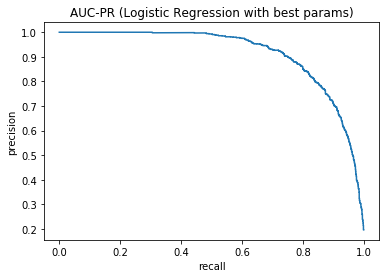

Area Under PR curve: 0.91501


In [29]:
logreg = LogisticRegression(max_iter=10000, penalty='l2', C=100, solver='newton-cg')

pipeline_logreg = Pipeline([
    ('categ_enc_', OneHotEncoder(cols=categorical_features)),
    ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
    ('scaler_', StandardScaler()),
    ('selector_', SelectKBest(score_func=mutual_info_classif, k=93)),
    ('model', logreg)
])

pipeline_logreg.fit(X_train_no_cust, y_train)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

y_pred_logreg = pipeline_logreg.predict_proba(X_test_no_cust)
precision, recall, thershold = precision_recall_curve(y_test, y_pred_logreg[:, 1])
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('AUC-PR (Logistic Regression with best params)')
plt.show()

print('Area Under PR curve:', round(auc(recall, precision), 5))

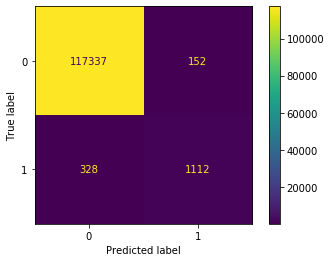

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_logreg = pipeline_logreg.predict(X_test_no_cust)
cm = confusion_matrix(y_test, y_pred_logreg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_logreg.classes_)
disp.plot();

In [24]:
# Мы получили оптимальные гиперпараметры
# Запустим гридсерч еще раз:

# Подбираем оптимальные кодировки для модели LogisticRegression

encoders_list = [OneHotEncoder, LeaveOneOutEncoder, TargetEncoder, WOEEncoder, MEstimateEncoder]

for encoder in encoders_list:
    pipeline = Pipeline([
        ('categ_enc_', encoder(cols=categorical_features)),
        ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
        ('scaler_', StandardScaler()),
        ('model_', LogisticRegression(max_iter=10000, penalty='l2', C=100, solver='newton-cg'))                
    ])

    crossval_results = cross_validate(
        pipeline,
        X_train.drop('customer', axis=1), 
        y_train, 
        cv=5,
        scoring='average_precision',
        n_jobs=-1,
        return_train_score=True
    )
    print(encoder.__name__, crossval_results['test_score'].mean())

OneHotEncoder 0.9282752501138283
LeaveOneOutEncoder 0.9084496525669404
TargetEncoder 0.9087021757443312
WOEEncoder 0.9144934830158202
MEstimateEncoder 0.9087005421517353


In [25]:
k_list = np.arange(90,99)

for k in k_list:
    pipe = Pipeline([
        ('categ_enc_', OneHotEncoder(cols=categorical_features+['kmeans'])),
        ('scaler_', StandardScaler()),
        ('selector_', SelectKBest(score_func=mutual_info_classif, k=k)),
        ('model_', LogisticRegression(max_iter=10000, penalty='l2', C=100, solver='newton-cg'))
    ])

    crossval_results = cross_validate(
        pipe, 
        X_train_no_cust, 
        y_train,
        cv=5, 
        scoring='average_precision',
        return_train_score=True
    )
    print(k, crossval_results['test_score'].mean())

90 0.9284456371809535
91 0.9283987743145536
92 0.9283502598207336
93 0.9283073541307815
94 0.9282745177208985
95 0.9282746368372059
96 0.928274312775098
97 0.9282755350094043
98 0.9282751261194864


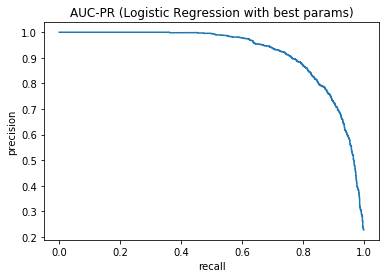

Area Under PR curve: 0.92051


In [47]:
logreg = LogisticRegression(max_iter=10000, penalty='l2', C=100, solver='lbfgs')

pipeline_logreg = Pipeline([
    ('categ_enc_', OneHotEncoder(cols=categorical_features)),
    ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
    ('scaler_', StandardScaler()),
    ('selector_', SelectKBest(score_func=mutual_info_classif, k=93)),
    ('model', logreg)
])

pipeline_logreg.fit(X_train_no_cust, y_train)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

y_pred_logreg = pipeline_logreg.predict_proba(X_test_no_cust)
precision, recall, thershold = precision_recall_curve(y_test, y_pred_logreg[:, 1])
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('AUC-PR (Logistic Regression with best params)')
plt.show()

print('Area Under PR curve:', round(auc(recall, precision), 5))

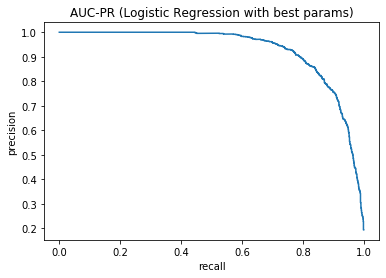

Area Under PR curve: 0.92726


In [43]:
logreg = LogisticRegression(max_iter=10000, penalty='l2', C=0.01, solver='saga')

pipeline_logreg = Pipeline([
    ('categ_enc_', OneHotEncoder(cols=categorical_features)),
    ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
    ('scaler_', StandardScaler()),
    ('selector_', SelectKBest(score_func=mutual_info_classif, k=93)),
    ('model', logreg)
])

pipeline_logreg.fit(X_train_no_cust, y_train)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

y_pred_logreg = pipeline_logreg.predict_proba(X_test_no_cust)
precision, recall, thershold = precision_recall_curve(y_test, y_pred_logreg[:, 1])
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('AUC-PR (Logistic Regression with best params)')
plt.show()

print('Area Under PR curve:', round(auc(recall, precision), 5))

In [ ]:
# Предыдущее значения качества данной модели: 0.91947

In [51]:
pipe = Pipeline([
        ('categ_enc_', OneHotEncoder(cols=categorical_features+['kmeans'])),
        ('scaler_', StandardScaler()),
        ('selector_', SelectKBest(score_func=mutual_info_classif, k=93)),
        ('model_', LogisticRegression(max_iter=10000, penalty='l2', C=100, solver='newton-cg'))
    ])

crossval_results = cross_validate(
        pipe, 
        X_train_no_cust, 
        y_train,
        cv=5, 
        scoring='average_precision',
        return_train_score=True
    )
print(crossval_results['test_score'].mean())

0.9282895541699758


In [52]:
pipe = Pipeline([
        ('categ_enc_', OneHotEncoder(cols=categorical_features+['kmeans'])),
        ('scaler_', StandardScaler()),
        ('selector_', SelectKBest(score_func=mutual_info_classif, k=93)),
        ('model_', LogisticRegression(max_iter=10000, penalty='l2', C=100, solver='lbfgs'))
    ])

crossval_results = cross_validate(
        pipe, 
        X_train_no_cust, 
        y_train,
        cv=5, 
        scoring='average_precision',
        return_train_score=True
    )
print(crossval_results['test_score'].mean())

0.9282524922240538


In [53]:
pipe = Pipeline([
        ('categ_enc_', OneHotEncoder(cols=categorical_features+['kmeans'])),
        ('scaler_', StandardScaler()),
        ('selector_', SelectKBest(score_func=mutual_info_classif, k=93)),
        ('model_', LogisticRegression(max_iter=10000, penalty='l2', C=0.01, solver='saga'))
    ])

crossval_results = cross_validate(
        pipe, 
        X_train_no_cust, 
        y_train,
        cv=5, 
        scoring='average_precision',
        return_train_score=True
    )
print(crossval_results['test_score'].mean())

0.9188246683031729


In [ ]:
# теперь на тесте

In [16]:
pipe = Pipeline([
        ('categ_enc_', OneHotEncoder(cols=categorical_features+['kmeans'])),
        ('scaler_', StandardScaler()),
        ('selector_', SelectKBest(score_func=mutual_info_classif, k=93)),
        ('model_', LogisticRegression(max_iter=10000, penalty='l2', C=100, solver='newton-cg'))
    ])

crossval_results = cross_validate(
        pipe, 
        X_test_no_cust, 
        y_test,
        cv=5, 
        scoring='average_precision',
        return_train_score=True,
    )
print(crossval_results['test_score'].mean())

0.9255011692766146


In [14]:
pipe = Pipeline([
        ('categ_enc_', OneHotEncoder(cols=categorical_features+['kmeans'])),
        ('scaler_', StandardScaler()),
        ('selector_', SelectKBest(score_func=mutual_info_classif, k=93)),
        ('model_', LogisticRegression(max_iter=10000, penalty='l2', C=100, solver='lbfgs'))
    ])

crossval_results = cross_validate(
        pipe, 
        X_test_no_cust, 
        y_test,
        cv=5, 
        scoring='average_precision',
        return_train_score=True,
    )
print(crossval_results['test_score'].mean())

0.9253723264623636


In [15]:
pipe = Pipeline([
        ('categ_enc_', OneHotEncoder(cols=categorical_features+['kmeans'])),
        ('scaler_', StandardScaler()),
        ('selector_', SelectKBest(score_func=mutual_info_classif, k=93)),
        ('model_', LogisticRegression(max_iter=10000, penalty='l2', C=0.01, solver='saga'))
    ])

crossval_results = cross_validate(
        pipe, 
        X_test_no_cust, 
        y_test,
        cv=5, 
        scoring='average_precision',
        return_train_score=True,
    )
print(crossval_results['test_score'].mean())

0.9206389199160057


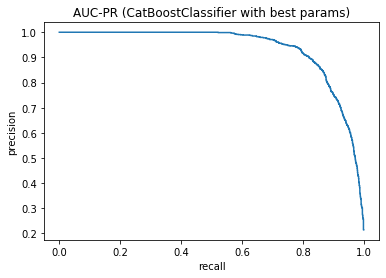

Area Under PR curve: 0.93624


In [32]:
catboostclass = CatBoostClassifier(logging_level='Silent', depth=3, iterations=500)

pipeline_catboost = Pipeline([
    ('categ_enc_', MEstimateEncoder(cols=categorical_features)),
    ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
    ('scaler_', StandardScaler()),
    ('model', catboostclass)
])

pipeline_catboost.fit(X_train_no_cust, y_train)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

y_pred_catboost = pipeline_catboost.predict_proba(X_test_no_cust)
precision, recall, thershold = precision_recall_curve(y_test, y_pred_catboost[:, 1])
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('AUC-PR (CatBoostClassifier with best params)')
plt.show()

print('Area Under PR curve:', round(auc(recall, precision), 5))

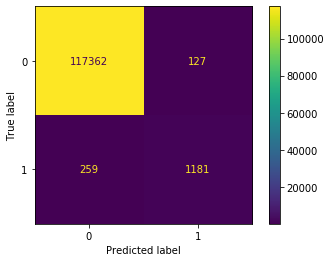

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_ctbst = pipeline_catboost.predict(X_test_no_cust)
cm = confusion_matrix(y_test, y_pred_ctbst)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_catboost.classes_)
disp.plot();

In [ ]:
# Предыдущее значения качества данной модели: 0.92621

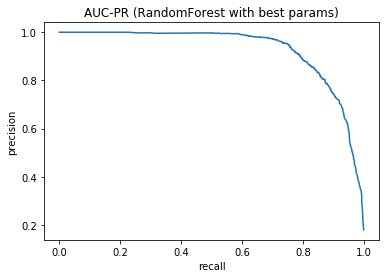

Area Under PR curve: 0.92889


In [34]:
rf = RandomForestClassifier(criterion='entropy', max_features='sqrt', n_estimators=700)

pipeline_rf = Pipeline([
    ('categ_enc_', TargetEncoder(cols=categorical_features)),
    ('kmeans_enc_', OneHotEncoder(cols=['kmeans'])),
    ('scaler_', StandardScaler()),
    ('selector_', SelectKBest(score_func=mutual_info_classif, k=17)),
    ('model', rf)
])

pipeline_rf.fit(X_train_no_cust, y_train)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

y_pred_rf = pipeline_rf.predict_proba(X_test_no_cust)
precision, recall, thershold = precision_recall_curve(y_test, y_pred_rf[:, 1])
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('AUC-PR (RandomForest with best params)')
plt.show()

print('Area Under PR curve:', round(auc(recall, precision), 5))

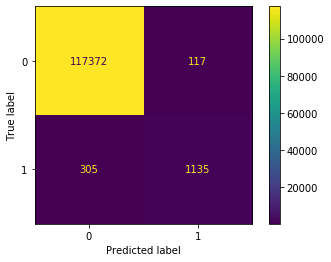

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_rf = pipeline_rf.predict(X_test_no_cust)
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_rf.classes_)
disp.plot();

In [ ]:
# Предыдущее значения качества данной модели: 0.91553

# Интерпретация моделей

In [17]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 686.9 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 908.8 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 610.5 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 604.7 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 635.8 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 899.1 kB/s eta 0:00:00a 0:00:01
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283845 sha256=9da95c6af31d87853fb740ca642ee39b541ee8f13a998774b3ef1f1ace0a8efc
  Stored in directory: /Users/matveykhylma/Library/Caches/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
You should consider upgrading via the '/Users/matveykhylma/miniconda3/bin/python -m pip install --upgrade pip' comma

In [12]:
!pip install shap

You should consider upgrading via the '/Users/matveykhylma/miniconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer

import shap
shap.initjs()

In [3]:
# логистическая регрессия, подготовка данных
encoder = OneHotEncoder(cols=categorical_features)
train = encoder.fit_transform(X_train_no_cust, y_train)
test  = encoder.transform(X_test_no_cust, y_test)

oheencoder = OneHotEncoder(cols=['kmeans'])
train = oheencoder.fit_transform(train)
test  = oheencoder.transform(test)

scaler = StandardScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

train = pd.DataFrame(train_scaled, index=train.index, columns=train.columns)
test = pd.DataFrame(test_scaled, index=test.index, columns=test.columns)

train

NameError: name 'OneHotEncoder' is not defined

In [96]:
selector = SelectKBest(score_func=mutual_info_classif, k=93)
train_select = selector.fit_transform(train, y_train)
test_select = selector.transform(test)

train_select

array([[ 2.11034584, -0.67828753, -0.32940164, ..., -0.60750294,
        -0.53969523, -0.21154798],
       [-0.47385598,  1.47430103, -0.32940164, ..., -0.47630341,
        -0.73134368, -0.21168884],
       [-0.47385598,  1.47430103, -0.32940164, ..., -0.15129785,
        -0.15891604, -0.20883895],
       ...,
       [-0.47385598, -0.67828753, -0.32940164, ..., -0.1917923 ,
        -0.47950015, -0.21151955],
       [ 2.11034584, -0.67828753, -0.32940164, ..., -0.26269711,
        -0.29827889, -0.21095831],
       [-0.47385598, -0.67828753, -0.32940164, ...,  0.24167358,
         0.65750018, -0.20978643]])

In [108]:
train = pd.DataFrame(train_select, index=train.index, columns=selector.get_feature_names_out())
test = pd.DataFrame(test_select, index=test.index, columns=selector.get_feature_names_out())

train

age_1     age_2     age_3     age_4     age_5     age_6     age_7  \
168395  2.110346 -0.678288 -0.329402 -0.216849 -0.573339 -0.343142 -0.063625   
368370 -0.473856  1.474301 -0.329402 -0.216849 -0.573339 -0.343142 -0.063625   
179485 -0.473856  1.474301 -0.329402 -0.216849 -0.573339 -0.343142 -0.063625   
118891 -0.473856  1.474301 -0.329402 -0.216849 -0.573339 -0.343142 -0.063625   
83228  -0.473856  1.474301 -0.329402 -0.216849 -0.573339 -0.343142 -0.063625   
...          ...       ...       ...       ...       ...       ...       ...   
54114  -0.473856  1.474301 -0.329402 -0.216849 -0.573339 -0.343142 -0.063625   
437159 -0.473856  1.474301 -0.329402 -0.216849 -0.573339 -0.343142 -0.063625   
127674 -0.473856 -0.678288 -0.329402 -0.216849 -0.573339  2.914245 -0.063625   
149824  2.110346 -0.678288 -0.329402 -0.216849 -0.573339 -0.343142 -0.063625   
398588 -0.473856 -0.678288 -0.329402  4.611512 -0.573339 -0.343142 -0.063625   

           age_8  gender_1  gender_2  ...  kmeans_1  kmeans_2  kmeans_3  \
168395 -0.044377  0.911673 -0.906494  ...  0.079784 -0.076392 -0.022884   
368370 -0.044377 -1.096884  1.103152  ...  0.079784 -0.076392 -0.022884   
179485 -0.044377  0.911673 -0.906494  ...  0.079784 -0.076392 -0.022884   
118891 -0.044377  0.911673 -0.906494  ...  0.079784 -0.076392 -0.022884   
83228  -0.044377 -1.096884  1.103152  ...  0.079784 -0.076392 -0.022884   
...          ...       ...       ...  ...       ...       ...       ...   
54114  -0.044377 -1.096884  1.103152  ...  0.079784 -0.076392 -0.022884   
437159 -0.044377 -1.096884  1.103152  ...  0.079784 -0.076392 -0.022884   
127674 -0.044377 -1.096884  1.103152  ...  0.079784 -0.076392 -0.022884   
149824 -0.044377  0.911673 -0.906494  ...  0.079784 -0.076392 -0.022884   
398588 -0.044377 -1.096884  1.103152  ...  0.079784 -0.076392 -0.022884   

         hdbscan     pca_x     pca_y     CBLOF      HBOS        IF       MCD  
168395  1.071879 -0.286260  0.327074 -0.364489 -0.607503 -0.539695 -0.211548  
368370  1.065935 -0.185961  0.362808 -0.264968 -0.476303 -0.731344 -0.211689  
179485  0.453681 -0.214584  0.272197 -0.175824 -0.151298 -0.158916 -0.208839  
118891  0.970828  0.033515  0.440097 -0.414831 -0.572354 -0.697680 -0.211658  
83228   1.054047 -0.205280  0.355817 -0.266611 -0.476303 -0.724485 -0.211679  
...          ...       ...       ...       ...       ...       ...       ...  
54114   0.768724 -0.091722  0.335166 -0.276730 -0.476303 -0.621408 -0.211641  
437159  1.166986 -0.215601  0.352770 -0.259383 -0.476303 -0.725125 -0.211664  
127674  0.697394 -0.140443  0.378822 -0.115410 -0.191792 -0.479500 -0.211520  
149824  0.174303 -0.115176  0.316401 -0.376849 -0.262697 -0.298279 -0.210958  
398588 -0.857017 -0.307599  0.311204  0.374630  0.241674  0.657500 -0.209786  

[475714 rows x 93 columns]

In [109]:
logreg = LogisticRegression(max_iter=10000, penalty='l2', C=100, solver='newton-cg')
logreg.fit(train, y_train)

LogisticRegression(C=100, max_iter=10000, solver='newton-cg')

In [1]:
ind = np.random.randint(0, test.shape[0])

NameError: name 'np' is not defined

In [115]:
# lime
class_names = [0, 1]
feature_names = list(train.columns.values)

lime_explainer = LimeTabularExplainer(train.values, feature_names = feature_names, class_names=class_names)

exp = lime_explainer.explain_instance(test.iloc[ind], logreg.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)

In [114]:
# shap
shap_explainer = shap.Explainer(logreg)
shap_values = shap_explainer(train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[ind])

Exception: The passed model is not callable and cannot be analyzed directly with the given masker! Model: LogisticRegression(C=100, max_iter=10000, solver='newton-cg')

In [ ]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[ind])

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
shap.summary_plot(shap_values)

## CatboostClassifier

In [12]:
# catboost classifier, подготовка данных
encoder = MEstimateEncoder(cols=categorical_features)
train = encoder.fit_transform(X_train_no_cust, y_train)
test  = encoder.transform(X_test_no_cust, y_test)

oheencoder = OneHotEncoder(cols=['kmeans'])
train = oheencoder.fit_transform(train)
test  = oheencoder.transform(test)

scaler = StandardScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

train = pd.DataFrame(train_scaled, index=train.index, columns=train.columns)
test = pd.DataFrame(test_scaled, index=test.index, columns=test.columns)

train

age    gender  merchant  category    amount  amount_outlier  \
168395  1.047290  0.907064  -0.15139 -0.194078 -0.286124       -0.073657   
368370  0.333189 -1.082489  -0.15139 -0.194078 -0.185810       -0.073657   
179485  0.333189  0.907064  -0.15139 -0.194078 -0.214484       -0.073657   
118891  0.333189  0.907064  -0.15139 -0.194078  0.033698       -0.073657   
83228   0.333189 -1.082489  -0.15139 -0.194078 -0.205132       -0.073657   
...          ...       ...       ...       ...       ...             ...   
54114   0.333189 -1.082489  -0.15139 -0.194078 -0.091584       -0.073657   
437159  0.333189 -1.082489  -0.15139 -0.194078 -0.215454       -0.073657   
127674 -1.116374 -1.082489  -0.15139 -0.194078 -0.140285       -0.073657   
149824  1.047290  0.907064  -0.15139 -0.194078 -0.115052       -0.073657   
398588 -2.419590 -1.082489  -0.15139 -0.194078 -0.307474       -0.073657   

        amount_outlier_2  strange_amount       pda       pdg  ...  kmeans_1  \
168395         -0.104933       -0.201718  0.936648  0.911673  ...  0.079784   
368370         -0.104933       -0.201718 -1.067637 -1.096884  ...  0.079784   
179485         -0.104933       -0.201718 -1.067637  0.911673  ...  0.079784   
118891         -0.104933       -0.201718 -1.067637  0.911673  ...  0.079784   
83228          -0.104933       -0.201718 -1.067637 -1.096884  ...  0.079784   
...                  ...             ...       ...       ...  ...       ...   
54114          -0.104933       -0.201718 -1.067637 -1.096884  ...  0.079784   
437159         -0.104933       -0.201718 -1.067637 -1.096884  ...  0.079784   
127674         -0.104933       -0.201718 -1.067637 -1.096884  ...  0.079784   
149824         -0.104933       -0.201718  0.936648  0.911673  ...  0.079784   
398588         -0.104933       -0.201718 -1.067637 -1.096884  ...  0.079784   

        kmeans_2  kmeans_3   hdbscan     pca_x     pca_y     CBLOF      HBOS  \
168395 -0.076392 -0.022884  1.071879 -0.286260  0.327074 -0.364489 -0.607503   
368370 -0.076392 -0.022884  1.065935 -0.185961  0.362808 -0.264968 -0.476303   
179485 -0.076392 -0.022884  0.453681 -0.214584  0.272197 -0.175824 -0.151298   
118891 -0.076392 -0.022884  0.970828  0.033515  0.440097 -0.414831 -0.572354   
83228  -0.076392 -0.022884  1.054047 -0.205280  0.355817 -0.266611 -0.476303   
...          ...       ...       ...       ...       ...       ...       ...   
54114  -0.076392 -0.022884  0.768724 -0.091722  0.335166 -0.276730 -0.476303   
437159 -0.076392 -0.022884  1.166986 -0.215601  0.352770 -0.259383 -0.476303   
127674 -0.076392 -0.022884  0.697394 -0.140443  0.378822 -0.115410 -0.191792   
149824 -0.076392 -0.022884  0.174303 -0.115176  0.316401 -0.376849 -0.262697   
398588 -0.076392 -0.022884 -0.857017 -0.307599  0.311204  0.374630  0.241674   

              IF       MCD  
168395 -0.539695 -0.211548  
368370 -0.731344 -0.211689  
179485 -0.158916 -0.208839  
118891 -0.697680 -0.211658  
83228  -0.724485 -0.211679  
...          ...       ...  
54114  -0.621408 -0.211641  
437159 -0.725125 -0.211664  
127674 -0.479500 -0.211520  
149824 -0.298279 -0.210958  
398588  0.657500 -0.209786  

[475714 rows x 25 columns]

In [13]:
catboostclass = CatBoostClassifier(logging_level='Silent', depth=3, iterations=500)
catboostclass.fit(train, y_train)

In [87]:
# lime
class_names = [0, 1]
feature_names = list(train.columns.values)

lime_explainer = LimeTabularExplainer(train.values, feature_names = feature_names, class_names=class_names)

exp = lime_explainer.explain_instance(test.loc[503391], catboostclass.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)

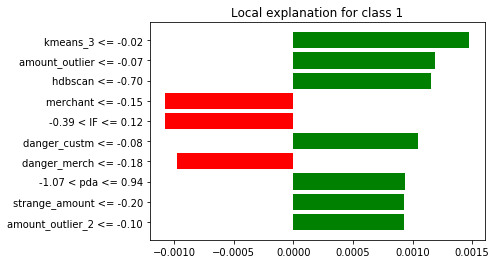

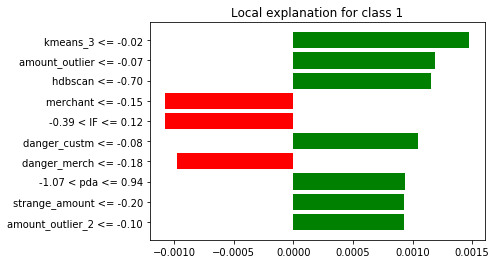

In [88]:
exp.as_pyplot_figure()

In [16]:
# lime
class_names = [0, 1]
feature_names = list(train.columns.values)

lime_explainer = LimeTabularExplainer(train.values, feature_names = feature_names, class_names=class_names)

exp = lime_explainer.explain_instance(test.iloc[ind+1], catboostclass.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)

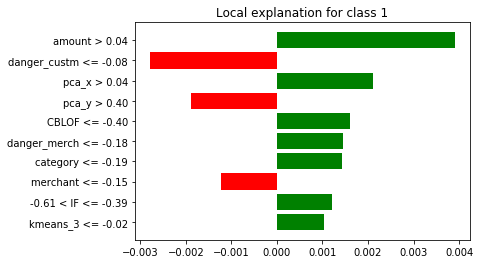

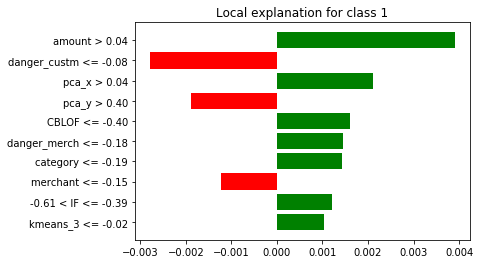

In [28]:
exp.as_pyplot_figure()

In [50]:
# lime, fraud
class_names = [0, 1]
feature_names = list(train.columns.values)

lime_explainer = LimeTabularExplainer(train.values, feature_names = feature_names, class_names=class_names)

exp = lime_explainer.explain_instance(test.loc[73333], catboostclass.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)

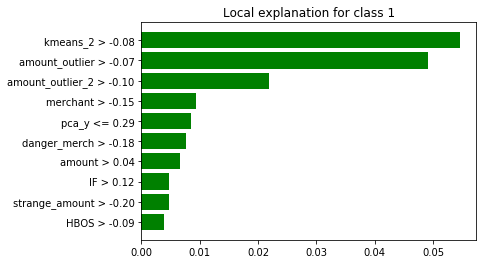

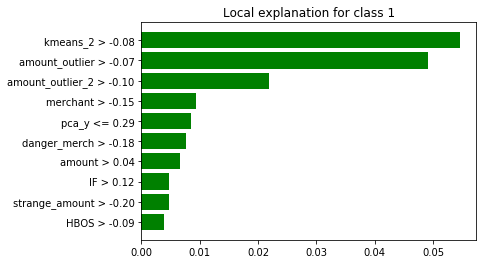

In [51]:
exp.as_pyplot_figure()

In [59]:
# shap
shap_explainer = shap.Explainer(catboostclass)
shap_values = shap_explainer(train)

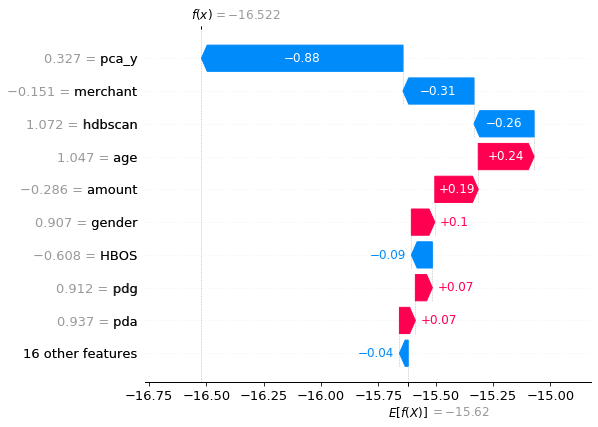

In [61]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [62]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

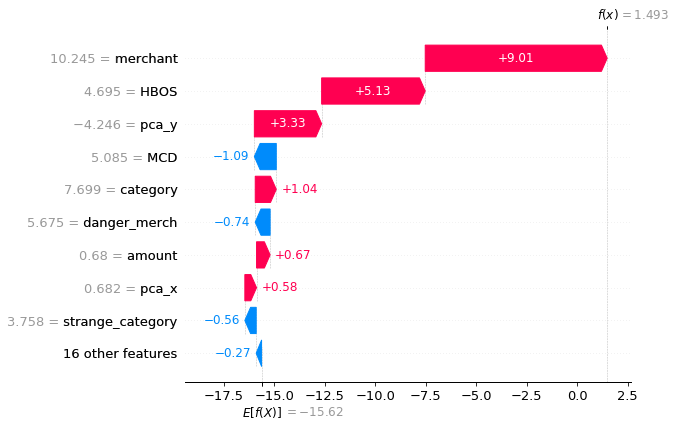

In [83]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[76])

In [84]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[76])

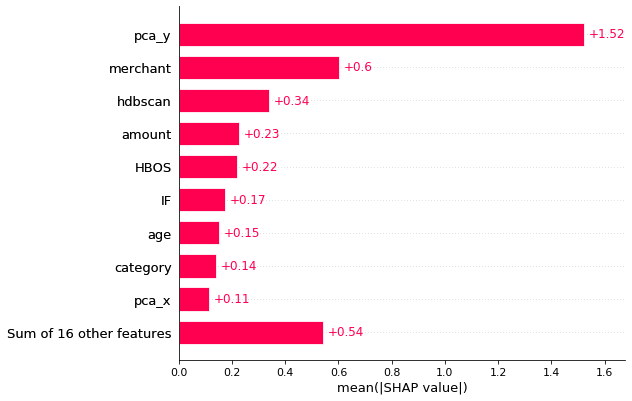

In [35]:
shap.plots.bar(shap_values)

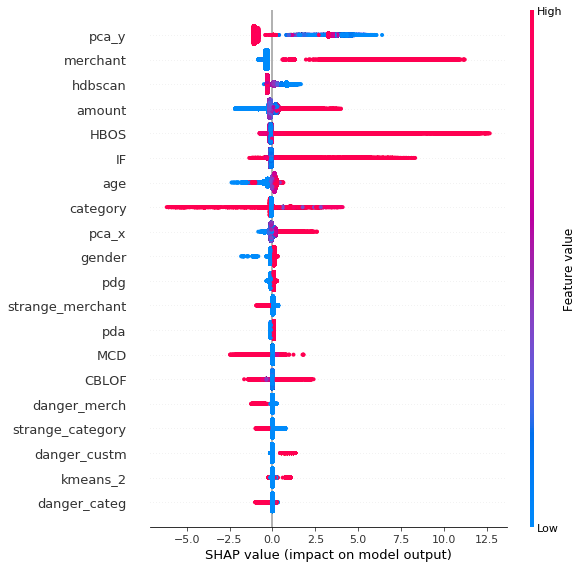

In [36]:
shap.summary_plot(shap_values)

## Random Forest

In [13]:
# подготовка данных
encoder = TargetEncoder(cols=categorical_features)
train = encoder.fit_transform(X_train_no_cust, y_train)
test  = encoder.transform(X_test_no_cust, y_test)

oheencoder = OneHotEncoder(cols=['kmeans'])
train = oheencoder.fit_transform(train)
test  = oheencoder.transform(test)

scaler = StandardScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

train = pd.DataFrame(train_scaled, index=train.index, columns=train.columns)
test = pd.DataFrame(test_scaled, index=test.index, columns=test.columns)

train

age    gender  merchant  category    amount  amount_outlier  \
168395  1.047069  0.907035 -0.151311 -0.193983 -0.286124       -0.073657   
368370  0.333116 -1.082425 -0.151311 -0.193983 -0.185810       -0.073657   
179485  0.333116  0.907035 -0.151311 -0.193983 -0.214484       -0.073657   
118891  0.333116  0.907035 -0.151311 -0.193983  0.033698       -0.073657   
83228   0.333116 -1.082425 -0.151311 -0.193983 -0.205132       -0.073657   
...          ...       ...       ...       ...       ...             ...   
54114   0.333116 -1.082425 -0.151311 -0.193983 -0.091584       -0.073657   
437159  0.333116 -1.082425 -0.151311 -0.193983 -0.215454       -0.073657   
127674 -1.116153 -1.082425 -0.151311 -0.193983 -0.140285       -0.073657   
149824  1.047069  0.907035 -0.151311 -0.193983 -0.115052       -0.073657   
398588 -2.419172 -1.082425 -0.151311 -0.193983 -0.307474       -0.073657   

        amount_outlier_2  strange_amount       pda       pdg  ...  kmeans_1  \
168395         -0.104933       -0.201718  0.936648  0.911673  ...  0.079784   
368370         -0.104933       -0.201718 -1.067637 -1.096884  ...  0.079784   
179485         -0.104933       -0.201718 -1.067637  0.911673  ...  0.079784   
118891         -0.104933       -0.201718 -1.067637  0.911673  ...  0.079784   
83228          -0.104933       -0.201718 -1.067637 -1.096884  ...  0.079784   
...                  ...             ...       ...       ...  ...       ...   
54114          -0.104933       -0.201718 -1.067637 -1.096884  ...  0.079784   
437159         -0.104933       -0.201718 -1.067637 -1.096884  ...  0.079784   
127674         -0.104933       -0.201718 -1.067637 -1.096884  ...  0.079784   
149824         -0.104933       -0.201718  0.936648  0.911673  ...  0.079784   
398588         -0.104933       -0.201718 -1.067637 -1.096884  ...  0.079784   

        kmeans_2  kmeans_3   hdbscan     pca_x     pca_y     CBLOF      HBOS  \
168395 -0.076392 -0.022884  1.071879 -0.286260  0.327074 -0.364489 -0.607503   
368370 -0.076392 -0.022884  1.065935 -0.185961  0.362808 -0.264968 -0.476303   
179485 -0.076392 -0.022884  0.453681 -0.214584  0.272197 -0.175824 -0.151298   
118891 -0.076392 -0.022884  0.970828  0.033515  0.440097 -0.414831 -0.572354   
83228  -0.076392 -0.022884  1.054047 -0.205280  0.355817 -0.266611 -0.476303   
...          ...       ...       ...       ...       ...       ...       ...   
54114  -0.076392 -0.022884  0.768724 -0.091722  0.335166 -0.276730 -0.476303   
437159 -0.076392 -0.022884  1.166986 -0.215601  0.352770 -0.259383 -0.476303   
127674 -0.076392 -0.022884  0.697394 -0.140443  0.378822 -0.115410 -0.191792   
149824 -0.076392 -0.022884  0.174303 -0.115176  0.316401 -0.376849 -0.262697   
398588 -0.076392 -0.022884 -0.857017 -0.307599  0.311204  0.374630  0.241674   

              IF       MCD  
168395 -0.539695 -0.211548  
368370 -0.731344 -0.211689  
179485 -0.158916 -0.208839  
118891 -0.697680 -0.211658  
83228  -0.724485 -0.211679  
...          ...       ...  
54114  -0.621408 -0.211641  
437159 -0.725125 -0.211664  
127674 -0.479500 -0.211520  
149824 -0.298279 -0.210958  
398588  0.657500 -0.209786  

[475714 rows x 25 columns]

In [14]:
selector = SelectKBest(score_func=mutual_info_classif, k=17)
train_select = selector.fit_transform(train, y_train)
test_select = selector.transform(test)

train_select

array([[ 0.90703499, -0.1513113 , -0.19398303, ..., -0.60750294,
        -0.53969523, -0.21154798],
       [-1.08242542, -0.1513113 , -0.19398303, ..., -0.47630341,
        -0.73134368, -0.21168884],
       [ 0.90703499, -0.1513113 , -0.19398303, ..., -0.15129785,
        -0.15891604, -0.20883895],
       ...,
       [-1.08242542, -0.1513113 , -0.19398303, ..., -0.1917923 ,
        -0.47950015, -0.21151955],
       [ 0.90703499, -0.1513113 , -0.19398303, ..., -0.26269711,
        -0.29827889, -0.21095831],
       [-1.08242542, -0.1513113 , -0.19398303, ...,  0.24167358,
         0.65750018, -0.20978643]])

In [15]:
train = pd.DataFrame(train_select, index=train.index, columns=selector.get_feature_names_out())
test = pd.DataFrame(test_select, index=test.index, columns=selector.get_feature_names_out())

train

gender  merchant  category    amount  amount_outlier_2       pda  \
168395  0.907035 -0.151311 -0.193983 -0.286124         -0.104933  0.936648   
368370 -1.082425 -0.151311 -0.193983 -0.185810         -0.104933 -1.067637   
179485  0.907035 -0.151311 -0.193983 -0.214484         -0.104933 -1.067637   
118891  0.907035 -0.151311 -0.193983  0.033698         -0.104933 -1.067637   
83228  -1.082425 -0.151311 -0.193983 -0.205132         -0.104933 -1.067637   
...          ...       ...       ...       ...               ...       ...   
54114  -1.082425 -0.151311 -0.193983 -0.091584         -0.104933 -1.067637   
437159 -1.082425 -0.151311 -0.193983 -0.215454         -0.104933 -1.067637   
127674 -1.082425 -0.151311 -0.193983 -0.140285         -0.104933 -1.067637   
149824  0.907035 -0.151311 -0.193983 -0.115052         -0.104933  0.936648   
398588 -1.082425 -0.151311 -0.193983 -0.307474         -0.104933 -1.067637   

             pdg  danger_merch  strange_category  strange_merchant  kmeans_1  \
168395  0.911673     -0.176197         -0.266107         -0.329688  0.079784   
368370 -1.096884     -0.176197         -0.266107         -0.329688  0.079784   
179485  0.911673     -0.176197         -0.266107         -0.329688  0.079784   
118891  0.911673     -0.176197         -0.266107         -0.329688  0.079784   
83228  -1.096884     -0.176197         -0.266107         -0.329688  0.079784   
...          ...           ...               ...               ...       ...   
54114  -1.096884     -0.176197         -0.266107         -0.329688  0.079784   
437159 -1.096884     -0.176197         -0.266107         -0.329688  0.079784   
127674 -1.096884     -0.176197         -0.266107         -0.329688  0.079784   
149824  0.911673     -0.176197         -0.266107         -0.329688  0.079784   
398588 -1.096884     -0.176197         -0.266107         -0.329688  0.079784   

         hdbscan     pca_x     CBLOF      HBOS        IF       MCD  
168395  1.071879 -0.286260 -0.364489 -0.607503 -0.539695 -0.211548  
368370  1.065935 -0.185961 -0.264968 -0.476303 -0.731344 -0.211689  
179485  0.453681 -0.214584 -0.175824 -0.151298 -0.158916 -0.208839  
118891  0.970828  0.033515 -0.414831 -0.572354 -0.697680 -0.211658  
83228   1.054047 -0.205280 -0.266611 -0.476303 -0.724485 -0.211679  
...          ...       ...       ...       ...       ...       ...  
54114   0.768724 -0.091722 -0.276730 -0.476303 -0.621408 -0.211641  
437159  1.166986 -0.215601 -0.259383 -0.476303 -0.725125 -0.211664  
127674  0.697394 -0.140443 -0.115410 -0.191792 -0.479500 -0.211520  
149824  0.174303 -0.115176 -0.376849 -0.262697 -0.298279 -0.210958  
398588 -0.857017 -0.307599  0.374630  0.241674  0.657500 -0.209786  

[475714 rows x 17 columns]

In [16]:
rf = RandomForestClassifier(criterion='entropy', max_features='sqrt', n_estimators=700)
rf.fit(train, y_train)

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       n_estimators=700)

In [17]:
ind = np.random.randint(0, test.shape[0])

In [22]:
# lime
class_names = [0, 1]
feature_names = list(train.columns.values)

lime_explainer = LimeTabularExplainer(train.values, feature_names = feature_names, class_names=class_names)

exp = lime_explainer.explain_instance(test.iloc[ind], rf.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [ ]:
# shap
shap_explainer = shap.Explainer(rf)
shap_values = shap_explainer(train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[ind])

In [ ]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[ind])

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
shap.summary_plot(shap_values)